In [1]:
# script to run simulations of stream peppering
import os, os.path
import csv
import time
import pickle
import matplotlib
#matplotlib.use('agg')
import numpy
from scipy import integrate, interpolate
from optparse import OptionParser
from galpy.util import bovy_conversion
import gd1_util
import pal5_util
from gd1_util import R0,V0
from scipy.integrate import quad
from scipy.optimize import brentq,fsolve
import GMC_GC_util
import glob
from galpy.util import bovy_conversion, bovy_coords, save_pickles, bovy_plot
from galpy.potential import MWPotential2014, turn_physical_off, vcirc
import astropy.units as u
%pylab inline
from galpy.orbit import Orbit
from scipy import ndimage, signal, interpolate
from numpy.polynomial import Polynomial
from gd1_util_MWhaloshape import lb_to_phi12

Populating the interactive namespace from numpy and matplotlib


In [2]:
def compute_obs_density_Pal5(xi,apars,dens_apar,Omega):
    
    apar_edge=[]
    xi_edge=[]

    abw0=apars[1]-apars[0]
    apar_edge.append(apars[0]-(abw0/2.))

    xibw0=xi[1]-xi[0]
    xi_edge.append(xi[0]-(xibw0/2.))

    for ii in range(len(apars)-1):
        abw=apars[ii+1]-apars[ii]
        xibw=xi[ii+1]-xi[ii]
        apar_edge.append(apars[ii]+abw/2.)
        xi_edge.append(xi[ii]+xibw/2.)

    abw_last=apars[len(apars)-1]-apars[len(apars)-2]
    apar_edge.append(apars[len(apars)-1]+(abw_last/2.))

    xibw_last=xi[len(xi)-1]-xi[len(xi)-2]
    xi_edge.append(xi[len(xi)-1]+(xibw_last/2.))

    #compute the Jacobian d(apar)/d(phi1) using finite difference method
    dapar_dxi=np.fabs(numpy.diff(apar_edge)/numpy.diff(xi_edge))
    #print (dapar_dphi1)
   
    #Interpolate dens(apar)
    ipdens_apar= interpolate.InterpolatedUnivariateSpline(apars,dens_apar)
    
    #Interpolate apar(phi1)
    ipxi= interpolate.InterpolatedUnivariateSpline(xi,apars)
    #Interpolate Jacobian
    ipdapar_dxi=interpolate.InterpolatedUnivariateSpline(xi,dapar_dxi)
    #Interpolate density(phi1) by multiplying by jacobian
    dens_xi=interpolate.InterpolatedUnivariateSpline(xi,ipdens_apar(ipxi(xi))*ipdapar_dxi(xi))
    #print (ipdens_apar(ipxi(xi))*ipdapar_dxi(xi))   
    return (dens_xi(xi))


def get_Pal5_data(minxi=0.25,poly_deg=3):
    #get the xi from the data
    # Read the data
    backg= 400.
    data= numpy.loadtxt('Pal5_data/ibata_fig7b_raw.dat',delimiter=',')
    sindx= numpy.argsort(data[:,0])
    data= data[sindx]
    data_lowerr= numpy.loadtxt('Pal5_data/ibata_fig7b_rawlowerr.dat',delimiter=',')
    sindx= numpy.argsort(data_lowerr[:,0])
    data_lowerr= data_lowerr[sindx]
    data_uperr= numpy.loadtxt('Pal5_data/ibata_fig7b_rawuperr.dat',delimiter=',')
    sindx= numpy.argsort(data_uperr[:,0])
    data_uperr= data_uperr[sindx]
    data_err= 0.5*(data_uperr-data_lowerr)
    # CUTS
    indx= (data[:,0] >= minxi-0.05)*(data[:,0] <= 14.35)
    data= data[indx]
    data_lowerr= data_lowerr[indx]
    data_uperr= data_uperr[indx]
    data_err= data_err[indx]
    # Compute power spectrum
    tdata= data[:,1]-backg
    pp= Polynomial.fit(data[:,0],tdata,deg=poly_deg,w=1./data_err[:,1])
    tdata/= pp(data[:,0])
    norm_data_err= data_err[:,1]/pp(data[:,0])
    
    return (data[:,0],tdata,norm_data_err)




def Pk_data(poly_deg=3,minxi=0.25,scaling='spectrum'):
    
    # Read the data
    backg= 400.
    data= numpy.loadtxt('Pal5_data/ibata_fig7b_raw.dat',delimiter=',')
    sindx= numpy.argsort(data[:,0])
    data= data[sindx]
    data_lowerr= numpy.loadtxt('Pal5_data/ibata_fig7b_rawlowerr.dat',delimiter=',')
    sindx= numpy.argsort(data_lowerr[:,0])
    data_lowerr= data_lowerr[sindx]
    data_uperr= numpy.loadtxt('Pal5_data/ibata_fig7b_rawuperr.dat',delimiter=',')
    sindx= numpy.argsort(data_uperr[:,0])
    data_uperr= data_uperr[sindx]
    data_err= 0.5*(data_uperr-data_lowerr)
    # CUTS
    indx= (data[:,0] >= minxi-0.05)*(data[:,0] <= 14.35)
    data= data[indx]
    data_lowerr= data_lowerr[indx]
    data_uperr= data_uperr[indx]
    data_err= data_err[indx]
    # Compute power spectrum
    tdata= data[:,1]-backg
    pp= Polynomial.fit(data[:,0],tdata,deg=poly_deg,w=1./data_err[:,1])
    tdata/= pp(data[:,0])
    data_err= data_err[:,1]/pp(data[:,0])
    ll= data[:,0]
    px_dat, py_dat= signal.csd(tdata,tdata,
                        fs=1./(ll[1]-ll[0]),scaling=scaling,
                        nperseg=len(ll))
    py_dat= py_dat.real
    px_dat= 1./px_dat
    py_dat= numpy.sqrt(py_dat*(ll[-1]-ll[0]))
    
    # Perform simulations of the noise to determine the power in the noise
    nerrsim= 10000
    ppy_err_dat= numpy.empty((nerrsim,len(px_dat)))

    ppy_noise=numpy.empty((nerrsim,len(px_dat)))

    for ii in range(nerrsim):
        tmock= data_err*numpy.random.normal(size=len(ll))
        tmock_noise= tdata + data_err*numpy.random.normal(size=len(ll))
        ppy_err_dat[ii]= signal.csd(tmock,tmock,
                                fs=1./(ll[1]-ll[0]),scaling='spectrum',
                                nperseg=len(ll))[1].real

        ppy_noise[ii]= signal.csd(tmock_noise,tmock_noise,
                                fs=1./(ll[1]-ll[0]),scaling='spectrum',
                                nperseg=len(ll))[1].real

    py_err_dat= numpy.sqrt(numpy.median(ppy_err_dat,axis=0)*(ll[-1]-ll[0]))

    ppy_noise_median = numpy.sqrt(numpy.nanmedian(ppy_noise,axis=0)*(ll[-1]-ll[0]))
    #print (ppy_noise_median- py_dat)

    ppy_noise.sort(axis=0)

    ppy_noise_low = numpy.sqrt(ppy_noise[int(numpy.round(0.023*nerrsim))]*(ll[-1]-ll[0]))
    ppy_noise_high = numpy.sqrt(ppy_noise[int(numpy.round(0.977*nerrsim))]*(ll[-1]-ll[0]))
    
    return (px_dat,ppy_noise_median,ppy_noise_low,ppy_noise_high,py_err_dat)

def compute_length_Pal5(xi_all,dens_xi_all,threshold=0.2):
    
    xi=xi_all[(xi_all >= 0.25) & (xi_all <= 14.35)]
    dens_xi=dens_xi_all[(xi_all >= 0.25) & (xi_all <= 14.35)]
    
    #first check if the density goes negative (due to interpolation of very small numbers.)
    if True in (dd < 0. for dd in dens_xi):
        length = 0.
            
    else :
        ip_dens_xi=interpolate.InterpolatedUnivariateSpline(xi,dens_xi)
          
        mean_den=np.mean(dens_xi[(xi >= 0.25) & (xi <= 3.)])
        #print ("mean den",mean_den*0.2)
        xi_fine=linspace(min(xi),max(xi),200)
        den_diff = ip_dens_xi(xi_fine) - threshold*mean_den
        
        if True in (d1<0. for d1 in den_diff):
            length = xi_fine[argmin(np.fabs(den_diff))] - 0.25
            #print (length)
            
        else:
            length = 14.1
            
        
        
        #xi_min=xi_fine[argmin(den_diff)]
        #print ("ximin",xi_min)
        #try:
        #    length=np.fabs(brentq(lambda x: ip_dens_xi(x)-mean_den*threshold,0.25,14.35)- 0.25)
            #length=np.fabs(fsolve(lambda x: ip_dens_xi(x)-mean_den*threshold,xi_min)[0]- 0.25)
            #print (length)
        #except ValueError as e:
        #    print (e)
        #    length = 14.35-(0.25) # full length
                        
    return (length)

def galcencyl_to_xieta(R,phi,Z,degree=True):
    l,b,d=np.array(galcencyl_to_lbd(R,phi,Z))
    radec=bovy_coords.lb_to_radec(l,b,degree=True) 
    mxieta=pal5_util.radec_to_pal5xieta(radec[:,0],radec[:,1],degree=True)
    xi= mxieta[:,0]
    eta=mxieta[:,1]
    return (xi,eta)

def bin_full_stream(p1,minx=-180.,maxx=180.,bw=0.5):
    
    bins_edge=np.arange(minx-bw,maxx+bw,bw) 
    #print ("min/max phi1 :",min(p1),max(p1))
    #print ("bin edges :",bins_edge)
    midphi1=[0.5*(bins_edge[i] + bins_edge[i+1]) for i in range(len(bins_edge)-1)]
    Ndn=np.histogram(p1,bins_edge)[0]
    Ndn_err=np.sqrt(Ndn)
    den=Ndn/(np.sum(Ndn)*bw)
    den_err=Ndn_err/(np.sum(Ndn)*bw)
    #print (np.sum(Ndn))
    return (midphi1,den,den_err)

def compute_dens_cont_xi(xi,dens_xi,outxi,deg=3):
    
    ip_dens_xi=interpolate.InterpolatedUnivariateSpline(xi,dens_xi)

    #compute polynomial and density at outxi
    ppdens_xi= Polynomial.fit(outxi,ip_dens_xi(outxi),deg=deg)

    #compute density contrast
    dens_cont=ip_dens_xi(outxi)/ppdens_xi(outxi)
    
    return (outxi,dens_cont)


def compute_obs_dens_from_file(fname,sdf_pepper):
    dat=np.loadtxt(fname)
    rate=dat[:,0][0]
    apars=dat[:,1]
    dens_smooth=dat[:,2]
    dens=dat[:,3]
    Omega=dat[:,5]
    mT= sdf_pepper.meanTrack(apars,_mO=Omega,coord='lb')
    mradec= bovy_coords.lb_to_radec(mT[0],mT[1],degree=True)
    mxieta= pal5_util.radec_to_pal5xieta(mradec[:,0],mradec[:,1],degree=True)
    dens_xi = compute_obs_density_Pal5(mxieta[:,0],apars,dens,Omega)
    #print (mxieta[:,0])
    return (rate,mxieta[:,0],dens_xi)


#power spectrum from dens already converted to observed coordinates
def compute_pk_sim(ll,tdata,scaling='spectrum'):
              
    px,py= signal.csd(tdata,tdata,fs=1./(ll[1]-ll[0]),scaling='spectrum',nperseg=len(ll))
    py= py.real
                 
    return (1./px,numpy.sqrt(py*(ll[-1]-ll[0])))

In [3]:
def compute_power_diff_rate(dir='dens_Omega/Pal5_sims_for_ABC_uniform_rate/',len_threshold=0.2,RaoblackwellizeN=100):
                  
    with open('pal5_pklfiles/pal5_smooth_pepper_td5.0_64sampling_MW2014.pkl','rb') as savefile:
            sdf_smooth= pickle.load(savefile,encoding='latin1')
            sdf_pepper= pickle.load(savefile,encoding='latin1')
    
    px_dat,py_noise_med,py_noise_low,py_noise_high,py_err_dat = Pk_data()
           
    fo = open('dens_Omega/Pal5_ABC_rate_power_diff_lenthreshold{}_barspiral_NRaoBlackwell{}.dat'.format(len_threshold,RaoblackwellizeN),'w',newline='')
        
    fowriter= csv.writer(fo,delimiter=',')
    fowriter.writerow([pp for pp in px_dat[1:]])
        
    xi_dat,norm_dat,norm_data_err = get_Pal5_data()
    
    len_dat=14.35 - 0.25
    
    midxi_BS,BS_pert=np.loadtxt('combine_bar_spiral_subhalos/Pal5_barspiral_1M_perturbation.dat',unpack=True)
    ip_BS_pert=interpolate.InterpolatedUnivariateSpline(midxi_BS,BS_pert)
    err_count=0 
    #rrate=[]
    allfname= glob.glob(dir + '*.dat')
    for fname in allfname :
        try:
            rate,xi,dens_xi=compute_obs_dens_from_file(fname,sdf_pepper)
            pert_BS=ip_BS_pert(xi)
            dens_tot = dens_xi+pert_BS
            mean_den=np.mean(dens_tot[(xi >= 0.25) & (xi <= 3.)])

            #compute length
            length = compute_length_Pal5(xi,dens_tot,threshold=0.2)
            #print (rate)
            #plt.figure()
            #plt.hlines(0.2*mean_den,0,17.)
            #plt.vlines(length,0.,0.5)
            #plt.plot(xi,dens_xi,label='subGMC')
            #plt.plot(xi,dens_tot,label='subGMC + BS')
            #plt.plot(xi,pert_BS)
            #plt.legend(loc='upper right')
            #plt.show()
            
            #if either arm is shorter than observed then PENALIZE! 
            if length < len_dat :
                #print ("rejected")
                #print (rate)
                prej = 100.*np.ones(len(px_dat)-1) #some huge number so that this gets rejected
                prej=np.insert(prej,0,rate)
                
                for ii in range(RaoblackwellizeN+1):
                    fowriter.writerow([p1 for p1 in prej])
                    
            else :
                #print ("hi")
                _,dens_cont=compute_dens_cont_xi(xi,dens_tot,xi_dat)
                #print (dens_cont)
                px_sim,py_sim = compute_pk_sim(xi_dat,dens_cont,scaling='spectrum')
                diff=np.fabs(py_sim[1:]-py_noise_med[1:])
                diff=np.insert(diff,0,rate)
                #print (diff)
                fowriter.writerow([pp for pp in diff])
                
                for jj in range(RaoblackwellizeN):
                    tdens= dens_cont+numpy.random.normal(size=len(xi_dat))*norm_data_err
                    
                    px_sim,py_sim = compute_pk_sim(xi_dat,tdens,scaling='spectrum')
                    
                    diff=np.fabs(py_sim[1:]-py_noise_med[1:])
                    
                    diff=np.insert(diff,0,rate)
                    
                    fowriter.writerow([pp for pp in diff])
                    
        except ValueError as e:
                err_count+=1
        #        print (fname)
                pass
                #print (jj)
        #        print (e)
                #os.rename(jj, trash_dir + fn) #move buggy realizations to trash 
    fo.flush()
    fo.close() 
    print (err_count)    
    return None
            
            

In [4]:
compute_power_diff_rate()

C:\Users\nbani\Anaconda3\lib\site-packages\ipykernel_launcher.py:102: RuntimeWarning: divide by zero encountered in true_divide

C:\Users\nbani\Anaconda3\lib\site-packages\ipykernel_launcher.py:227: RuntimeWarning: divide by zero encountered in true_divide

C:\Users\nbani\Anaconda3\lib\site-packages\galpy\util\bovy_coords.py:569: RuntimeWarning: invalid value encountered in less
  l[cosl < 0.]= nu.pi-l[cosl < 0.]

C:\Users\nbani\Anaconda3\lib\site-packages\galpy\util\bovy_coords.py:570: RuntimeWarning: invalid value encountered in greater_equal
  l[(cosl >= 0.)*(sinl < 0.)]+= 2.*nu.pi

C:\Users\nbani\Anaconda3\lib\site-packages\galpy\util\bovy_coords.py:570: RuntimeWarning: invalid value encountered in less
  l[(cosl >= 0.)*(sinl < 0.)]+= 2.*nu.pi

C:\Users\nbani\Anaconda3\lib\site-packages\astropy\coordinates\angles.py:642: RuntimeWarning: invalid value encountered in less
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):

C:\Users\nbani\Anaconda3\lib\sit

In [36]:
# Do a Epanechnikov KDE estimate of the PDF in the transformed y=(1+x)/(1-x) space
def kde_epanechnikov_rate(x,h,ydata):
    """ydata= ln[(2+xdata)/(2-xdata)]"""
    h= numpy.ones_like(x)*h
    h[x < -0.5]= h[x < -0.5]*(-2.*(x[x < -0.5]+0.5)+1.) # use slightly wider kernel at small values
    y= numpy.log((2.1+x)/(2.1-x))
    #r= numpy.fabs(numpy.tile(y,(len(ydata),1)).T-ydata)/h
    r= numpy.fabs(numpy.tile(y,(len(ydata),1)).T-ydata)/numpy.tile(h,(len(ydata),1)).T
    r[r > 1.]= 1. # Gets around multi-D slicing
    return numpy.sum(0.75*(1.-r**2.),axis=1)/h*(1./(2.1+x)+1./(2.1-x))

def kde_epanechnikov_rate1(x,h,ydata):
    """ydata= ln[(1+xdata)/(1-xdata)]"""
    h= numpy.ones_like(x)*h
    #h[x < -0.5]= h[x < -0.5]*(-2.*(x[x < -0.5]+0.5)+1.) # use slightly wider kernel at small values
    y= numpy.log((1.1+x)/(1.01-x))
    #r= numpy.fabs(numpy.tile(y,(len(ydata),1)).T-ydata)/h
    r= numpy.fabs(numpy.tile(y,(len(ydata),1)).T-ydata)/numpy.tile(h,(len(ydata),1)).T
    r[r > 1.]= 1. # Gets around multi-D slicing
    return numpy.sum(0.75*(1.-r**2.),axis=1)/h*(1./(1.1+x)+1./(1.1-x))


def kde_epanechnikov_slope(x,h,ydata):
    
    h= numpy.ones_like(x)*h
    h[x < -0.5]= h[x < -0.5]*(-2.*(x[x < -0.5]+0.5)+1.) # use slightly wider kernel at small values
    y= numpy.log((2.6+x)/(-1.4-x))
    #print (y)
    #r= numpy.fabs(numpy.tile(y,(len(ydata),1)).T-ydata)/h
    r= numpy.fabs(numpy.tile(y,(len(ydata),1)).T-ydata)/numpy.tile(h,(len(ydata),1)).T
    r[r > 1.]= 1. # Gets around multi-D slicing
    return numpy.sum(0.75*(1.-r**2.),axis=1)/h*np.abs(1./(2.6+x) - 1./(1.4+x))

def kde_epanechnikov_amp(x,h,ydata):
    
    h= numpy.ones_like(x)*h
    h[x < -0.5]= h[x < -0.5]*(-2.*(x[x < -0.5]+0.5)+1.) # use slightly wider kernel at small values
    y= numpy.log((1.1+x)/(1.1-x))
    #r= numpy.fabs(numpy.tile(y,(len(ydata),1)).T-ydata)/h
    r= numpy.fabs(numpy.tile(y,(len(ydata),1)).T-ydata)/numpy.tile(h,(len(ydata),1)).T
    r[r > 1.]= 1. # Gets around multi-D slicing
    return numpy.sum(0.75*(1.-r**2.),axis=1)/h*(1./(1.1+x)+1./(1.1-x))

def kde_epanechnikov_mwdm(x,h,ydata):
    """ydata= ln[(1+xdata)/(1-xdata)]"""
    h= numpy.ones_like(x)*h
    #h[x < -0.5]= h[x < -0.5]*(-2.*(x[x < -0.5]+0.5)+1.) # use slightly wider kernel at small values
    y= numpy.log((x-(0.01-0.005))/(1.1-x))
    #print (y)
    #r= numpy.fabs(numpy.tile(y,(len(ydata),1)).T-ydata)/h
    r= numpy.fabs(numpy.tile(y,(len(ydata),1)).T-ydata)/numpy.tile(h,(len(ydata),1)).T
    r[r > 1.]= 1. # Gets around multi-D slicing
    return numpy.sum(0.75*(1.-r**2.),axis=1)/h*np.abs(1./(x-(0.01-0.005)) + 1./(1.1-x))

def kde_epanechnikov_weighted_mwdm_uniform(x,h,xdata):
    """ydata= ln[(1+xdata)/(1-xdata)]"""
    h= numpy.ones_like(x)*h
    ydata=numpy.log((xdata-(1. - 0.1))/(30.1-xdata))
    h[x < -0.5]= h[x < -0.5]*(-2.*(x[x < -0.5]+0.5)+1.) # use slightly wider kernel at small values
    y= numpy.log((x-(1.-0.1))/(30.1-x))
    #print (y)
    #r= numpy.fabs(numpy.tile(y,(len(ydata),1)).T-ydata)/h
    r= numpy.fabs(numpy.tile(y,(len(ydata),1)).T-ydata)/numpy.tile(h,(len(ydata),1)).T
    r[r > 1.]= 1. # Gets around multi-D slicing
    return numpy.sum(0.75*(1.-r**2.)/xdata**2.,axis=1)/h*np.abs(1./(x-(1.-0.1)) + 1./(30.1-x))


import seaborn as sns
def plot_pdf(rate_array,dat_type='rate',color=sns.color_palette()[0],zorder=8,
                  kernel_width=0.8,
                  add_68peak_95up=False,add_95up=False,add_95low=False,
                  overplot=False,
                  scale=1.,label=''):
    
    rate_full= np.array(rate_array)#abc_full[sindx,0]
    
    if dat_type == 'rate':
        xxs= numpy.linspace(-0.95,1.,200)
        kdey_full= kde_epanechnikov_rate1(xxs,kernel_width,numpy.log((1.1+rate_full)/(1.1-rate_full)))+numpy.random.uniform(size=len(xxs))*0.000001
        kdey_full/= numpy.sum(kdey_full)*(xxs[1]-xxs[0])  
        bovy_plot.bovy_plot(xxs,kdey_full*scale,'-',lw=3.,color=color,zorder=zorder,overplot=overplot,label=label)
        #print (kdey_full)
        if add_68peak_95up:
            # Get peak and 68% around the peak
            bf= xxs[numpy.argmax(kdey_full)]
            sindx= numpy.argsort(-kdey_full) # minus reverses sort
            cp= numpy.cumsum((kdey_full/numpy.sum(kdey_full))[sindx])
            m68= xxs[sindx][cp > 0.68]
            uplim68= numpy.amin(m68[m68 > bf])
            lowlim68= numpy.amax(m68[m68 < bf])
            cp= numpy.cumsum(kdey_full)/numpy.sum(kdey_full)
            uplim_95= interpolate.InterpolatedUnivariateSpline(cp,xxs,k=1)(0.95)
            bovy_plot.bovy_text(r'$\mathrm{rate} = %.1f^{+%.1f}_{-%.1f} \times \mathrm{CDM}\ (68\,\%%)$' \
                                % (10.**bf,10.**uplim68-10.**bf,10.**bf-10.**lowlim68)+'\n'+r'$\mathrm{rate} < %.1f \times \mathrm{CDM}\ (95\,\%%)$' % (10**uplim_95),
                                size=16.,top_left=True)


        if add_95up:
            # Get 95% upper limit
            cp= numpy.cumsum(kdey_full)/numpy.sum(kdey_full)
            uplim_95= interpolate.InterpolatedUnivariateSpline(cp,xxs,k=1)(0.95)
            bovy_plot.bovy_text(r'$\mathrm{rate} < %.1f \times \mathrm{CDM}\ (95\,\%%)$' % (10.**uplim_95),
                               size=16.,top_left=True)

        if add_95low:
            # Get 95% lower limit
            #compute complementary CDF = 1- CDF
            ccp= numpy.ones(len(kdey_full)) - numpy.cumsum(kdey_full)/numpy.sum(kdey_full)
            lowlim_95= interpolate.InterpolatedUnivariateSpline(ccp[::-1],xxs[::-1],k=1)(0.95)
            
            bovy_plot.bovy_text(r'$\mathrm{rate} >%.4f \times \mathrm{CDM}\ (95\,\%%)$' % (10.**lowlim_95),
                               size=16.,top_left=True)
        legend(loc='lower left')
        return None
    
    elif dat_type == 'slope':
        xxs= numpy.linspace(-2.5,-1.5,101)
        kdey_full= kde_epanechnikov_slope(xxs,kernel_width,numpy.log((2.6+rate_full)/(-1.4-rate_full)))\
            +numpy.random.uniform(size=len(xxs))*0.000001
        kdey_full/= numpy.sum(kdey_full)*(xxs[1]-xxs[0])  

        #print (kdey_full)
        bovy_plot.bovy_plot(xxs,kdey_full*scale,'-',lw=3.,color=color,zorder=zorder,overplot=overplot,label=label)
        if add_68peak_95up:
            # Get peak and 68% around the peak
            bf= xxs[numpy.argmax(kdey_full)]
            sindx= numpy.argsort(-kdey_full) # minus reverses sort
            cp= numpy.cumsum((kdey_full/numpy.sum(kdey_full))[sindx])
            m68= xxs[sindx][cp > 0.68]
            uplim68= numpy.amin(m68[m68 > bf])
            lowlim68= numpy.amax(m68[m68 < bf])
            cp= numpy.cumsum(kdey_full)/numpy.sum(kdey_full)
            uplim_95= interpolate.InterpolatedUnivariateSpline(cp,xxs,k=1)(0.95)
            bovy_plot.bovy_text(r'$\alpha = %.1f^{+%.1f}_{-%.1f} \ (68\,\%%)$' \
                                % (bf,uplim68-bf,bf-lowlim68)+'\n'+r'$\alpha < %.1f \ (95\,\%%)$' % (uplim_95),
                                size=16.,top_left=True)


        if add_95up:
            # Get 95% upper limit
            cp= numpy.cumsum(kdey_full)/numpy.sum(kdey_full)
            uplim_95= interpolate.InterpolatedUnivariateSpline(cp,xxs,k=1)(0.95)
            bovy_plot.bovy_text(r'$\alpha < %.1f \ (95\,\%%)$' % (uplim_95),
                               size=16.,top_left=True)

        if add_95low:
            # Get 95% lower limit
            #compute complementary CDF = 1- CDF
            ccp= numpy.ones(len(kdey_full)) - numpy.cumsum(kdey_full)/numpy.sum(kdey_full)
            lowlim_95= interpolate.InterpolatedUnivariateSpline(ccp[::-1],xxs[::-1],k=1)(0.95)
            bovy_plot.bovy_text(r'$\alpha >%.1f \ (95\,\%%)$' % (lowlim_95),
                               size=16.,top_left=True)

        legend(loc='upper right')
        return None
    
    elif dat_type == 'amp' : 
        xxs= numpy.linspace(-1.,1.,101)
        kdey_full= kde_epanechnikov_amp(xxs,kernel_width,numpy.log((1.1+rate_full)/(1.1-rate_full)))\
            +numpy.random.uniform(size=len(xxs))*0.000001
        kdey_full/= numpy.sum(kdey_full)*(xxs[1]-xxs[0])  
        bovy_plot.bovy_plot(xxs,kdey_full*scale,'-',lw=3.,color=color,zorder=zorder,overplot=overplot,label=label)
        if add_68peak_95up:
            # Get 95% upper limit
            cp= numpy.cumsum(kdey_full)/numpy.sum(kdey_full)
            uplim_95= interpolate.InterpolatedUnivariateSpline(cp,xxs,k=1)(0.95)
            # Get peak and 68% around the peak
            bf= xxs[numpy.argmax(kdey_full)]
            sindx= numpy.argsort(-kdey_full) # minus reverses sort
            cp= numpy.cumsum((kdey_full/numpy.sum(kdey_full))[sindx])
            m68= xxs[sindx][cp > 0.68]
            uplim68= numpy.amin(m68[m68 > bf])
            lowlim68= numpy.amax(m68[m68 < bf])
            bovy_plot.bovy_text(r'$\mathrm{amp} = %.1f^{+%.1f}_{-%.1f} \times \mathrm{CDM}\ (68\,\%%)$' \
                                % (10.**bf,10.**uplim68-10.**bf,10.**bf-10.**lowlim68)
                                +'\n'+r'$\mathrm{amp} < %.1f \times \mathrm{CDM}\ (95\,\%%)$' % (10.**uplim_95),
                               size=16.,top_left=True)
            
        if add_95up:
            # Get 95% upper limit
            cp= numpy.cumsum(kdey_full)/numpy.sum(kdey_full)
            uplim_95= interpolate.InterpolatedUnivariateSpline(cp,xxs,k=1)(0.95)
            bovy_plot.bovy_text(r'$\mathrm{amp} < %.1f \times \mathrm{CDM}\ (95\,\%%)$' % (10.**uplim_95),
                               size=16.,top_left=True)

        if add_95low:
            # Get 95% lower limit
            #compute complementary CDF = 1- CDF
            ccp= numpy.ones(len(kdey_full)) - numpy.cumsum(kdey_full)/numpy.sum(kdey_full)
            lowlim_95= interpolate.InterpolatedUnivariateSpline(ccp[::-1],xxs[::-1],k=1)(0.95)
            bovy_plot.bovy_text(r'$\mathrm{amp} > %.1f \times \mathrm{CDM}\ (95\,\%%)$' % (10.**lowlim_95),
                               size=16.,top_left=True)

                   
        legend(loc='upper right')
        return None
    
    elif dat_type=='mwdm':
        xxs= numpy.linspace(0.01,1.,101)
        kdey_full= kde_epanechnikov_mwdm(xxs,kernel_width,numpy.log((rate_full-(0.01 - 0.005))/(1.1-rate_full)))\
            +numpy.random.uniform(size=len(xxs))*0.000001
        kdey_full/= numpy.sum(kdey_full)*(xxs[1]-xxs[0])  

        #print (kdey_full)
        bovy_plot.bovy_plot(xxs,kdey_full*scale,'-',lw=3.,color=color,zorder=zorder,overplot=overplot,label=label)
        if add_68peak_95up:
            # Get peak and 68% around the peak
            bf= xxs[numpy.argmax(kdey_full)]
            sindx= numpy.argsort(-kdey_full) # minus reverses sort
            cp= numpy.cumsum((kdey_full/numpy.sum(kdey_full))[sindx])
            m68= xxs[sindx][cp > 0.68]
            uplim68= numpy.amin(m68[m68 > bf])
            lowlim68= numpy.amax(m68[m68 < bf])
            cp= numpy.cumsum(kdey_full)/numpy.sum(kdey_full)
            uplim_95= interpolate.InterpolatedUnivariateSpline(cp,xxs,k=1)(0.95)
            bovy_plot.bovy_text(r'$m_{\mathrm{WDM}} = %.1f^{+%.1f}_{-%.1f} \ (68\,\%%)$' \
                                % (bf,uplim68-bf,bf-lowlim68)+'\n'+r'$\alpha < %.1f \ (95\,\%%)$' % (uplim_95),
                                size=16.,top_left=True)


        if add_95up:
            # Get 95% upper limit
            cp= numpy.cumsum(kdey_full)/numpy.sum(kdey_full)
            uplim_95= interpolate.InterpolatedUnivariateSpline(cp,xxs,k=1)(0.95)
            bovy_plot.bovy_text(r'$1/m_{\mathrm{WDM}} < %.3f \ \mathrm{keV} \ (95\,\%%)$' % (uplim_95),
                               size=16.,top_left=True)

        if add_95low:
            # Get 95% lower limit
            #compute complementary CDF = 1- CDF
            ccp= numpy.ones(len(kdey_full)) - numpy.cumsum(kdey_full)/numpy.sum(kdey_full)
            lowlim_95= interpolate.InterpolatedUnivariateSpline(ccp[::-1],xxs[::-1],k=1)(0.95)
            bovy_plot.bovy_text(r'$1/m_{\mathrm{WDM}} >%.3f \ \mathrm{keV} \ (95\,\%%)$' % (lowlim_95),
                               size=16.,top_left=True)

        legend(loc='upper right')
        
    elif dat_type=='weighted_mwdm_uniform':
        xxs= numpy.linspace(1.,29.,201)
        kdey_full= kde_epanechnikov_weighted_mwdm_uniform(xxs,kernel_width,rate_full)+numpy.random.uniform(size=len(xxs))*0.000001
        kdey_full/= numpy.sum(kdey_full)*(xxs[1]-xxs[0])  

        #print (kdey_full)
        bovy_plot.bovy_plot(xxs,kdey_full*scale,'-',lw=3.,color=color,zorder=zorder,overplot=overplot,label=label)
        if add_68peak_95up:
            # Get peak and 68% around the peak
            bf= xxs[numpy.argmax(kdey_full)]
            sindx= numpy.argsort(-kdey_full) # minus reverses sort
            cp= numpy.cumsum((kdey_full/numpy.sum(kdey_full))[sindx])
            m68= xxs[sindx][cp > 0.68]
            uplim68= numpy.amin(m68[m68 > bf])
            lowlim68= numpy.amax(m68[m68 < bf])
            cp= numpy.cumsum(kdey_full)/numpy.sum(kdey_full)
            uplim_95= interpolate.InterpolatedUnivariateSpline(cp,xxs,k=1)(0.95)
            bovy_plot.bovy_text(r'$m_{\mathrm{WDM}} = %.1f^{+%.1f}_{-%.1f} \ (68\,\%%)$' \
                                % (bf,uplim68-bf,bf-lowlim68)+'\n'+r'$\alpha < %.1f \ (95\,\%%)$' % (uplim_95),
                                size=16.,top_left=True)


        if add_95up:
            # Get 95% upper limit
            cp= numpy.cumsum(kdey_full)/numpy.sum(kdey_full)
            uplim_95= interpolate.InterpolatedUnivariateSpline(cp,xxs,k=1)(0.95)
            bovy_plot.bovy_text(r'$m_{\mathrm{WDM}} < %.3f \ \mathrm{keV} \ (95\,\%%)$' % (uplim_95),
                               size=16.,top_left=True)

        if add_95low:
            # Get 95% lower limit
            #compute complementary CDF = 1- CDF
            ccp= numpy.ones(len(kdey_full)) - numpy.cumsum(kdey_full)/numpy.sum(kdey_full)
            lowlim_95= interpolate.InterpolatedUnivariateSpline(ccp[::-1],xxs[::-1],k=1)(0.95)
            bovy_plot.bovy_text(r'$m_{\mathrm{WDM}} >%.3f \ \mathrm{keV} \ (95\,\%%)$' % (lowlim_95),
                               size=16.,top_left=True)

        legend(loc='upper right')
        
        
        return None

In [9]:
abc_diff=np.loadtxt('dens_Omega/Pal5_ABC_rate_power_diff_lenthreshold{}_barspiral_NRaoBlackwell{}.dat'.format(0.2,100),delimiter=',',skiprows=1)

tol_hi=0.6
tol_med=0.5
tol_lo=0.4

accepted_rate=[]
NN=len(abc_diff)


for ii in range(NN):
    #print (abc_diff[ii])
    rate=abc_diff[ii][0]
    
    diff_hi=abc_diff[ii][1]
    diff_med=abc_diff[ii][2]
    diff_lo=abc_diff[ii][3]
    
    #print (diff_hi,diff_med,diff_lo)
    if (diff_hi < tol_hi) and (diff_med < tol_med) and (diff_lo < tol_lo):
    #if (diff_le_hi < tol_le_hi) and (diff_le_med < tol_le_med) and (diff_le_lo < tol_le_lo):    
        accepted_rate.append(np.log10(rate))
                        
print (len(abc_diff), len(accepted_rate))

996769 241744


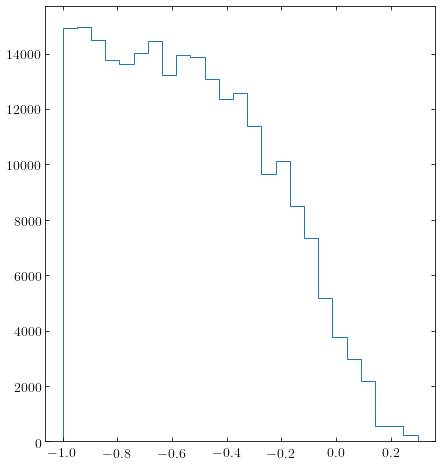

In [21]:
plt.figure()
plt.hist(accepted_rate,bins=25,histtype='step')
plt.show()

No handles with labels found to put in legend.


(0.0, 1.53)

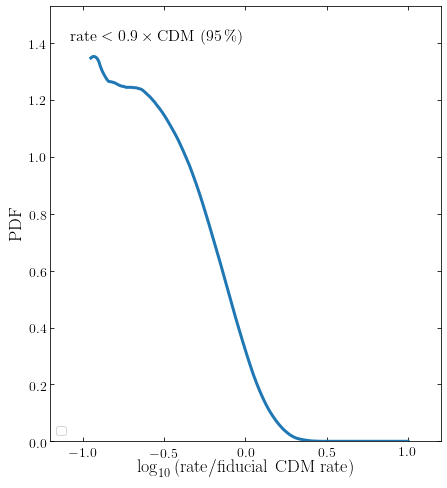

In [37]:
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(7.,8.)
cmap= cm.plasma

plot_pdf(accepted_rate,dat_type='rate',kernel_width=0.5,add_95up=True,scale=1.,label='',overplot=True)
xlabel(r'$\log_{10}\left(\mathrm{rate}/\mathrm{fiducial\ CDM\ rate}\right)$')
ylabel(r'$\mathrm{PDF}$')
xlim(-1.2,1.2)
ylim(0.,1.53)

#savefig("posterior_lognormal3sigmaamp_slope_uniform_weighted_logmwdm.pdf")